## Using Real data with ImageGenerator
File system에서 ImageGenerator 사용을 연습해보자.

### Load data
#### 1. Image(data) 다운받기
흠 예시코드가 이렇게 되어있는데 이러면 tmp 경로에 파일을 저장하지 않나 왜 굳이 tmp에 하는거지?

In [1]:
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip -O /tmp/horse-or-human.zip

--2021-01-13 18:16:07--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 34.64.4.16, 34.64.4.80, 2404:f340:10:1800::2010, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|34.64.4.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M  8.45MB/s    in 20s     

2021-01-13 18:16:28 (7.07 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]



zip 파일 추출은 여기 하위 data 디렉터리에 저장하는게 편할 것 같아서 바꿨당

In [2]:
import os
import zipfile

local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./data/horse-or-human')
zip_ref.close()

The contents of the .zip are extracted to the base directory ~~/tmp/horse-or-human~~ /data/horse-or-human, which in turn each contain horses and humans subdirectories.

In short: The training set is the data that is used to tell the neural network model that 'this is what a horse looks like', 'this is what a human looks like' etc.

#### 2. ImageGenerator에서 사용할 디렉터리 가리키기
디렉토리를 변수로 설정해야 ImageGenerator가 가리킬 수 있다.

The next thing is for us to set up our directories as variables, so we can point the generators at them.

In [3]:
# Directory with our training horse pictures
train_horse_dir = os.path.join('./data/horse-or-human/horses')

# Directory with our training human pictures
train_human_dir = os.path.join('./data/horse-or-human/humans')

### EDA & Preprocessing

In [4]:
train_horse_names = os.listdir(train_horse_dir)
print(train_horse_names[:10])

train_human_names = os.listdir(train_human_dir)
print(train_human_names[:10])

['horse27-7.png', 'horse21-9.png', 'horse14-3.png', 'horse11-2.png', 'horse03-8.png', 'horse42-4.png', 'horse19-0.png', 'horse49-5.png', 'horse10-0.png', 'horse25-9.png']
['human10-10.png', 'human10-09.png', 'human08-10.png', 'human17-17.png', 'human08-11.png', 'human13-04.png', 'human10-27.png', 'human14-21.png', 'human01-11.png', 'human06-30.png']


In [5]:
print('total training horse images:', len(os.listdir(train_horse_dir)))
print('total training human images:', len(os.listdir(train_human_dir)))

total training horse images: 500
total training human images: 527


In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

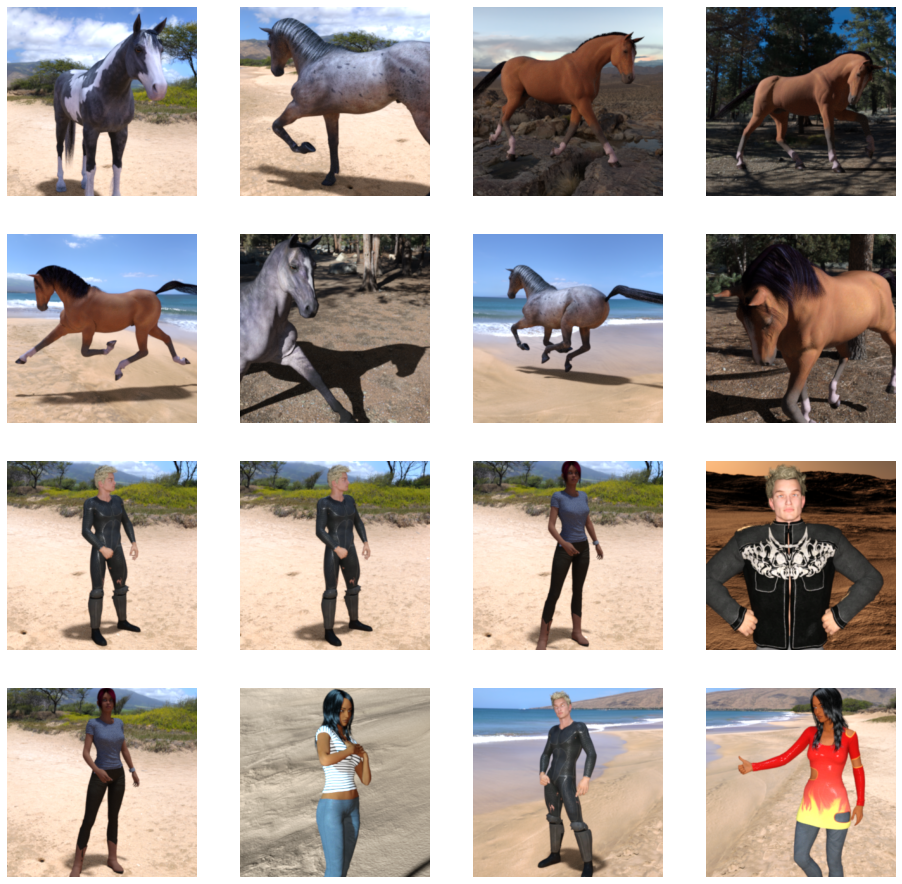

In [7]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_horse_pix = [os.path.join(train_horse_dir, fname) for fname in train_horse_names[pic_index-8:pic_index]]
next_human_pix = [os.path.join(train_human_dir, fname) for fname in train_human_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_horse_pix+next_human_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

In [8]:
test_dir = os.listdir(train_human_dir)
test_name = test_dir[0]
test_name

'human10-10.png'

In [9]:
test_path = os.path.join(train_human_dir, test_name)
test_path

'./data/horse-or-human/humans/human10-10.png'

In [10]:
from PIL import Image
test_img = Image.open(test_path)
test_img.size

(300, 300)

요새 들어서 느끼는건데 시각화가 제일 까다롭고 어려운거 같애...

### Modeling
주의점 : binary classification이니까 modeling 마지막에 softmax말고 sigmoid 쓸거임
* sigmoid는 0~1 사이의 확률값을 반환한다. class 0은 0에 가까운 값을 반환하고, class 1은 1에 가까운 값을 반환한다.
* 따라서 마지막 layer의 neuron은 1개여야 함!
* Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')

In [11]:
import tensorflow as tf

In [12]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [13]:
model = tf.keras.Sequential([
    # 이미지니까 Convolutional layer를 끼얹어 볼까
    # input_shape은 위에서 구한 이미지 사이즈로 맞춰주자
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300,300,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    # 기본 DNN 구조
    # Flatten the 2D result to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        3

In [15]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

binary classification이니까 loss도 binary_crossentropy 사용. optimizer는 Adam 말고 RMSprop도 써 보자.
* RMSprop 특징 : Learning rate(`lr` 파라미터)를 조정해가면서 optimize 가능
* In this case, using the RMSprop optimization algorithm is preferable to stochastic gradient descent (SGD), because RMSprop automates learning-rate tuning for us. (Other optimizers, such as Adam and Adagrad, also automatically adapt the learning rate during training, and would work equally well here.)

### Data Preprocessing to use ImageGenerator
근데 왜 모델링 하고 나서 이걸 하지? 순서가 바뀌면 안되나?
* 나는 modeling 전으로 하는게 깔끔하다 생각

Let's set up data generators that will read pictures in our source folders, convert them to float32 tensors, and feed them (with their labels) to our network.
* Our generators will yield batches of images of size 300x300 and their labels (binary).
* normalize : `keras.preprocessing.image.ImageDataGenerator`
* instantiate(인스턴스화) : `.flow(data, labels)` or `.flow_from_directory(dir)`
* 이후 generator는 input Keras model method로써 사용될 수 있다.
    * `fit`, `evaluate_generator`, `predict_generator`

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Normalize
train_datagen = ImageDataGenerator(rescale=1/255)

# Instantiate
# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    './data/horse-or-human/', # train dir
    target_size=(300,300),
    batch_size=128,
    class_mode='binary' # binary_crossentropy loss를 사용하므로 binary labels 필요
)

Found 1027 images belonging to 2 classes.


`target_size=(300,300)`에서  All images will be resized to 150x150 라는데 왜그런지 모르겠다.
* 300X300이 맞음. 뒤에서 150x150으로 테스트하기 때문에 써있는 주석이었음

### Traning
Each epochs is loading the data, calculating the convolutions and then trying to match the convolutions to labels.

In [17]:
history = model.fit(
    train_generator,
    steps_per_epoch=8,
    epochs=15,
    verbose=1
)

Epoch 1/15


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential/conv2d/Conv2D (defined at <ipython-input-17-3a0f3e819092>:5) ]] [Op:__inference_train_function_1187]

Function call stack:
train_function


자꾸 지피유 메모리 초과 때문에 문제가 발생한다....ㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠ

## Predict
모델이 잘 맞추고 있는지 테스트

파일 시스템으로부터 이미지를 업로드하면 해당 이미지가 말인지 사람인지 판별한다.

#### Colob용 코드

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
    # predicting images
    path = '/content/' + fn
    img = image.load_img(path, target_size=(300, 300))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    print(classes[0])
    
    if classes[0]>0.5:
        print(fn + " is a human")
    else:
        print(fn + " is a horse")

#### Local에서는 어떻게 할 수 있을까

### Visualizing
이건 중요한 거는 아니고 그냥 convolution 과정 보는거임

visualize how an input gets transformed as it goes through the convnet.

Let's pick a random image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map. Rerun this cell to generate intermediate representations for a variety of training images.

In [ ]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
# Let's prepare a random input image from the training set.
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)

img = load_img(img_path, target_size=(300, 300))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers[1:]]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

## Clean up
이건 중요함!!! 커널을 종료하고 memory resource 해제하기

Before running the next exercise, run the following cell to terminate the kernel and free memory resources:

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)